In [1]:
import requests
import layoutparser as lp

In [2]:
r = requests.get("https://cac.annauniv.edu/PhpProject1/aidetails/afug_2017_fu/01.%20B.E.EEE.pdf", verify=False)
with open("test.pdf", 'wb') as fp:
    fp.write(r.content)

/home/iamharish/lastpage-syllabus-parser/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cac.annauniv.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [3]:
pdf_tokens, pdf_images = lp.load_pdf("test.pdf", load_images=True)

In [4]:
model = lp.Detectron2LayoutModel(
    config_path = "./outputs/lastpage/fast_rcnn_R_50_FPN_3x/config.yaml",
    model_path = "./outputs/lastpage/fast_rcnn_R_50_FPN_3x/model_final.pth",
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # <-- Only output high accuracy preds
)

In [5]:
layout = model.detect(pdf_images[24])

/home/iamharish/lastpage-syllabus-parser/venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


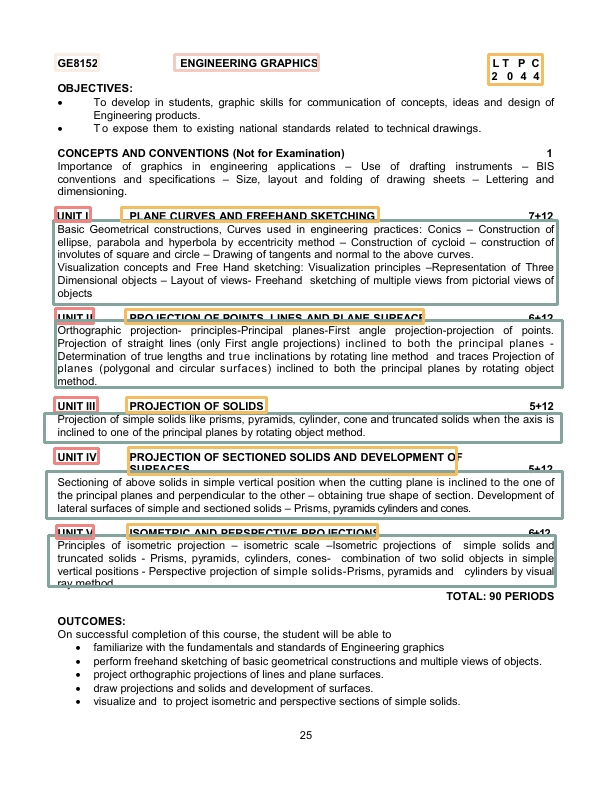

In [6]:
lp.draw_box(pdf_images[24], layout)

In [7]:
layout_data = layout.to_dataframe()
layout_data

,x_1,y_1,x_2,y_2,block_type,type,score
0,48.410271,535.778931,555.133301,586.890381,rectangle,5,0.999931
1,174.830582,54.898022,318.526337,70.695145,rectangle,4,0.999915
2,55.279491,308.547577,93.190590,323.605804,rectangle,6,0.999832
3,53.142029,220.702362,557.617004,304.494385,rectangle,5,0.999564
4,55.981758,320.822601,562.117920,387.616913,rectangle,5,0.999551
5,55.151070,207.366806,90.569641,221.999435,rectangle,6,0.999528
6,54.027691,397.413666,97.143112,412.152130,rectangle,6,0.999493
7,44.425983,413.417755,561.007996,442.559509,rectangle,5,0.999436
8,127.677864,524.677917,377.266815,538.544067,rectangle,7,0.999435
9,56.708004,525.008240,93.564705,538.125671,rectangle,6,0.999418


#### Sort Page Contents Based on Relative Positions

In [25]:
page_contents = {} 

for page_index in range(len(pdf_images)): # Pages with Subject-Level Data 
    syllabus_items = model.detect(pdf_images[page_index])
    
    page_syllabus_tokens = []
    for syllabus_item in syllabus_items:
        syllabus_tokens = pdf_tokens[page_index].filter_by(syllabus_item, center=True)
        page_syllabus_tokens.append(syllabus_tokens)
        
    # MAGIC - Sorted based on position coordinate. Check LayoutParser's Layout.filter_by()
    page_syllabus_tokens = sorted(page_syllabus_tokens, key=lambda tokens: min([ele.id for ele in tokens]))
    
    page_contents[page_index] = [" ".join(syllabus_tokens.get_texts()) for syllabus_tokens in page_syllabus_tokens]



In [26]:
import pandas as pd 

(pd
 .DataFrame(tuple(page_contents.items()), 
             columns=['page_index', 'extracted_data'])
 .explode('extracted_data')
 .reset_index(drop=True)
)[:30]

,page_index,extracted_data
0,0,NaN
1,1,SEM I
2,1,SEM II
3,2,SEM IV
4,2,SEM V
5,3,SEM VI
6,3,SEM VII
7,4,NaN
8,5,NaN
9,6,NaN


In [19]:
page_contents

{22: ['GE8151',
  'PROBLEM SOLVING AND PYTHON PROGRAMMING',
  'L T P C 3 0 0 3',
  'UNIT I',
  'ALGORITHMIC PROBLEM SOLVING',
  'Algorithms, building blocks of algorithms (statements, state, control flow, functions), notation (pseudo code, flow chart, programming language), algorithmic problem solving, simple strategies for developing algorithms (iteration, recursion). Illustrative problems: find minimum in a list, insert a card in a list of sorted cards, guess an integer number in a range, Towers of Hanoi.',
  'UNIT II',
  'DATA, EXPRESSIONS, STATEMENTS',
  'Python interpreter and interactive mode; values and types: int, float, boolean, string, and list; variables, expressions, statements, tuple assignment, precedence of operators, comments; modules and functions, function definition and use, flow of execution, parameters and arguments; Illustrative programs: exchange the values of two variables, circulate the values of n variables, distance between two points.'],
 23: ['UNIT III',
  

In [108]:
page_contents_mod = {} 

for page_index in range(len(pdf_images)): # Pages with Subject-Level Data 
    syllabus_items = model.detect(pdf_images[page_index])
    
    page_syllabus_tokens = []
    for syllabus_item in syllabus_items:
        syllabus_tokens = pdf_tokens[page_index].filter_by(syllabus_item, center=True)
        token_class = syllabus_item.type # Include COCO Category ID for downstream data processing
        page_syllabus_tokens.append(tuple([token_class, syllabus_tokens]))
        
    # MAGIC - Sorted based on position coordinate. Check LayoutParser's Layout.filter_by()
    page_syllabus_tokens = sorted(page_syllabus_tokens, key=lambda tokens: min([ele.id for ele in tokens[1]])) #tokens[0] contains category ID and tokens[1] contains the actual tokens
    
    page_contents_mod[page_index] = [tuple([syllabus_tokens[0], " ".join(syllabus_tokens[1].get_texts())]) for syllabus_tokens in page_syllabus_tokens]



#### Split tuples of (category_id, data) into separate columns

This way, category_id can be joined with coco dataset to obtain correct category names

In [131]:
from numpy import NaN
import pandas as pd

# Split each of the page's bbox-contents into a separate record
df = pd.DataFrame(tuple(page_contents_mod.items()), columns=["page_index", "extracted_data"]).explode("extracted_data").reset_index(drop=True)

# Replace NaN values in extracted data with tuples for data uniformity
df['extracted_data'] = df['extracted_data'].apply(lambda x: (NaN,NaN) if x is NaN else x)

# Split (category_id, data) tuples into separate columns
df = df.join(pd.DataFrame(df['extracted_data'].tolist(), columns=['category_id', 'data']))

# Data preview
df[20:40]


,page_index,extracted_data,category_id,data
20,16,"(4, COMMUNICATIVE ENGLISH)",4.0,COMMUNICATIVE ENGLISH
21,16,"(0, L T P C 4 0 0 4)",0.0,L T P C 4 0 0 4
22,16,"(6, UNIT I)",6.0,UNIT I
23,16,"(7, SHARING INFORMATION RELATED TO ONESELF/FAM...",7.0,SHARING INFORMATION RELATED TO ONESELF/FAMILY&...
24,16,"(5, Reading - short comprehension passages, pr...",5.0,"Reading - short comprehension passages, practi..."
25,16,"(6, UNIT II)",6.0,UNIT II
26,16,"(7, GENERAL READING AND FREE WRITING)",7.0,GENERAL READING AND FREE WRITING
27,16,"(5, Reading - comprehension-pre-reading-post r...",5.0,Reading - comprehension-pre-reading-post readi...
28,16,"(6, UNIT III)",6.0,UNIT III
29,16,"(7, GRAMMAR AND LANGUAGE DEVELOPMENT)",7.0,GRAMMAR AND LANGUAGE DEVELOPMENT


Load category_id mappings from coco dataset used for training

In [132]:
import json

# read test dataset (smaller size)
with open("./data/annotations/test.json", mode='r') as coco_test_ds:
    coco_test_data = json.load(coco_test_ds)

# reduce list of category dictionaries into key value pairs
categories = coco_test_data["categories"]
category_names = {}
for category in categories:
    category_names[category["id"]] = category["name"]

category_names

{0: 'LTPC',
 1: 'recommReference',
 2: 'recommTextbook',
 3: 'subjectCode',
 4: 'subjectTitle',
 5: 'unitContents',
 6: 'unitNumber',
 7: 'unitTitle'}

Convert categories dict into Pandas DataFrame

In [133]:
categories_lookup = pd.DataFrame(category_names.items(), columns = ['category_id', 'name'])

categories_lookup

,category_id,name
0,0,LTPC
1,1,recommReference
2,2,recommTextbook
3,3,subjectCode
4,4,subjectTitle
5,5,unitContents
6,6,unitNumber
7,7,unitTitle


Update master dataframe with category names based on category_id

In [136]:

df = df.merge(categories_lookup, on = 'category_id', how='left')

Create subset of master with only the required columns

In [137]:
df_minimal = df[['page_index', 'category_id', 'name', 'data']]

df_minimal[:20]

,page_index,category_id,name,data
0,0,NaN,NaN,NaN
1,1,3.0,subjectCode,SEM I
2,1,3.0,subjectCode,SEM II
3,2,3.0,subjectCode,SEM IV
4,2,3.0,subjectCode,SEM V
5,3,3.0,subjectCode,SEM VI
6,3,3.0,subjectCode,SEM VII
7,4,NaN,NaN,NaN
8,5,NaN,NaN,NaN
9,6,NaN,NaN,NaN


In [139]:
df_minimal.to_csv('./test_export.csv')